In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.optim
import torch.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

In [2]:
mb_size = 100 # mini-batch size of 100


trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

dataset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)


Processing...
Done!


In [ ]:
#test set
test_dataset = dset.MNIST("./", download = True,
                     train = False,
                     transform = trans)


test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=10000,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)

In [3]:
def init_weights(shape):
    # xavier initialization (a good initialization is important!)
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    fan_in = shape[0]
    fan_out = shape[1]
    variance = 2.0/(fan_in + fan_out)
    w = torch.randn(size=shape)*np.sqrt(variance)
    w.requires_grad = True
    return w

def rectify(X):
    return torch.max(torch.zeros_like(X), X)


# you can also use torch.nn.functional.softmax on future sheets
def softmax(X):
    c = torch.max(X, dim=1)[0].reshape(mb_size, 1)
    # this avoids a blow up of the exponentials
    # but calculates the same formula
    stabelized = X-c
    exp = torch.exp(stabelized)
    return exp/torch.sum(exp, dim=1).reshape(mb_size, 1)


# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.9, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(1 - alpha, grad, grad)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(-group['lr'], grad, avg)


## Raw model

In [ ]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    #X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    #h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    #h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [0]:
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))
optimizer = RMSprop([w_h, w_h2, w_o])

for i in range(10):
    print('Epoch %i'%(i+1))
    for (j, (X, y)) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        cost.backward()
        if j%100==0:
            print("Loss: {}".format(cost))
        optimizer.step()

Epoch 1
Loss: 2.4383063316345215
Loss: 0.45292049646377563
Loss: 0.1624702513217926
Loss: 0.314606636762619
Loss: 0.37931641936302185
Loss: 0.2577272355556488
Epoch 2
Loss: 0.2254757285118103
Loss: 0.177986279129982
Loss: 0.09745069593191147
Loss: 0.1130680963397026
Loss: 0.16060322523117065
Loss: 0.13469071686267853
Epoch 3
Loss: 0.08190114051103592
Loss: 0.16590620577335358
Loss: 0.1779492199420929
Loss: 0.03844417631626129
Loss: 0.07598592340946198
Loss: 0.19877488911151886
Epoch 4
Loss: 0.07959254086017609
Loss: 0.05046374723315239
Loss: 0.11108023673295975
Loss: 0.09400580078363419
Loss: 0.10574810951948166
Loss: 0.0358109287917614
Epoch 5
Loss: 0.1245107650756836
Loss: 0.06308893859386444
Loss: 0.04351544380187988
Loss: 0.1330675184726715
Loss: 0.02346799522638321
Loss: 0.05445188656449318
Epoch 6
Loss: 0.06675520539283752
Loss: 0.12438568472862244
Loss: 0.21986620128154755
Loss: 0.07772628217935562
Loss: 0.018264278769493103
Loss: 0.02790614403784275
Epoch 7
Loss: 0.162283852696

In [ ]:
#calculate test accuracy
def test_acc(weights,model):
    for (_, (X, y)) in enumerate(test_dataloader, 0):
        pred=torch.max(model(X.reshape(test_dataloader.batch_size, -1), *weights,),1)[1]
        err=np.count_nonzero(pred.numpy()==y.numpy())/test_dataloader.batch_size
    return err

In [0]:
test_acc([ w_h, w_h2, w_o, 0.8, 0.7],model)

0.97

Initial test error: 97%

## With Dropout

In [5]:
def dropout(X,p_drop=1):
    if p_drop<0 or p_drop>1:
        return X
    mask=np.random.binomial(1,p_drop,X.shape)
    X = X * torch.tensor(mask).type(torch.FloatTensor)
    return X/p_drop

In [ ]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    #h = PRelu(X @ w_h,a)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    #h2 = PRelu(h @ w_h2,a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

the dropout method sets randomly a certain percentage of the weights to zero. This reduces overfitting as it prevents that specific weights counter act each other. 

In [23]:
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

for i in range(10):
    print('Epoch %i'%(i+1))
    for (j, (X, y)) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        cost.backward()
        if j%100==0:
            print("Loss: {}".format(cost))
        optimizer.step()

Epoch 1
Loss: 2.870680332183838
Loss: 0.9895469546318054
Loss: 0.44895243644714355
Loss: 0.35955145955085754
Loss: 0.42591896653175354
Loss: 0.3463113009929657
Epoch 2
Loss: 0.3647099733352661
Loss: 0.5683982968330383
Loss: 0.23462322354316711
Loss: 0.36871135234832764
Loss: 0.29702872037887573
Loss: 0.26043036580085754
Epoch 3
Loss: 0.21323558688163757
Loss: 0.12817656993865967
Loss: 0.0769650861620903
Loss: 0.1589348167181015
Loss: 0.10127487033605576
Loss: 0.17777320742607117
Epoch 4
Loss: 0.11273083090782166
Loss: 0.14847451448440552
Loss: 0.2707211375236511
Loss: 0.4120597839355469
Loss: 0.1962129920721054
Loss: 0.23093529045581818
Epoch 5
Loss: 0.08885368704795837
Loss: 0.31845036149024963
Loss: 0.1479317545890808
Loss: 0.11292293667793274
Loss: 0.29015690088272095
Loss: 0.28360989689826965
Epoch 6
Loss: 0.12882612645626068
Loss: 0.2815173268318176
Loss: 0.06088335067033768
Loss: 0.2516140043735504
Loss: 0.22176986932754517
Loss: 0.10832227766513824
Epoch 7
Loss: 0.25051298737525

In [24]:
test_acc([w_h, w_h2, w_o, 0.8, 0.7],model)

0.9462

## With Parametric Relu

In [ ]:
def PRelu (X,a):
    z = torch.tensor(X, requires_grad=True)
    z = z*a[0]
    z[z >= 0] = X[z >= 0]
    return z

In [0]:
def model(X, w_h, w_h2, w_o, a,p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = PRelu(X @ w_h,a)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2,a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [29]:
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))
#prelu constant
a_2 = init_weights((1,625))
optimizer = RMSprop([*w_conv1, w_h2, w_o, a_2])

for i in range(10):
    print('Epoch %i'%(i+1))
    for (j, (X, y)) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o,a_2, 0.8, 0.7)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        cost.backward()
        if j%100==0:
            print("Loss: {}".format(cost))
        optimizer.step()

Epoch 1
Loss: 2.8057448863983154


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Loss: 0.9584658741950989
Loss: 0.5390554666519165
Loss: 0.43708187341690063
Loss: 0.552754282951355
Loss: 0.6651925444602966
Epoch 2
Loss: 0.42307403683662415
Loss: 0.5108500123023987
Loss: 0.6477224230766296
Loss: 0.4062381088733673
Loss: 0.5530341863632202
Loss: 0.34933072328567505
Epoch 3
Loss: 0.2801732122898102
Loss: 0.5084130764007568
Loss: 0.3599422574043274
Loss: 0.3402005732059479
Loss: 0.2535078823566437
Loss: 0.4418446719646454
Epoch 4
Loss: 0.40707945823669434
Loss: 0.3395109176635742
Loss: 0.5701867938041687
Loss: 0.22224725782871246
Loss: 0.499553918838501
Loss: 0.2131744921207428
Epoch 5
Loss: 0.2767999768257141
Loss: 0.26099830865859985
Loss: 0.3587254285812378
Loss: 0.40119126439094543
Loss: 0.21230147778987885
Loss: 0.42506009340286255
Epoch 6
Loss: 0.19191144406795502
Loss: 0.515203058719635
Loss: 0.3134538531303406
Loss: 0.5087266564369202
Loss: 0.33230167627334595
Loss: 0.5998152494430542
Epoch 7
Loss: 0.13249428570270538
Loss: 0.17606639862060547
Loss: 0.447415381

In [31]:
test_error([w_h, w_h2, w_o,a_2, 0.8, 0.7])

0.91

# 5 Convolutional layers

In [ ]:
def model(X, w_conv1, w_h2, w_o, a_2, p_drop_input, p_drop_hidden,number_of_output_pixel=128):
    X = X.reshape(-1, 1, 28, 28)
    X = dropout(X, p_drop_input)
    for i in range(len(w_conv1)):
        convolutional_layer = rectify(conv2d(X, w_conv1[i] ))
        subsample_layer = max_pool2d(convolutional_layer, (2, 2)) # reduces window 2x2 to 1 pixel
        X = dropout(subsample_layer, p_drop_input )
    X = X.reshape((-1,number_of_output_pixel))
    h2 = PRelu(X @ w_h2,a_2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [7]:
w_1 = init_weights((32, 1, 5, 5))
w_2 = init_weights((64, 32, 5, 5))
w_3 = init_weights((128, 64, 2, 2))
w_conv1 = [w_1, w_2, w_3]

w_h2 = init_weights((128, 625))
w_o = init_weights((625, 10))
#prelu constant
a_2 = init_weights((1,625))
optimizer = RMSprop([*w_conv1, w_h2, w_o, a_2])

for i in range(10):
    print('Epoch %i'%i)
    for (j, (X, y)) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        noise = torch.tensor([])
        noise=model(X.reshape(mb_size, 784), w_conv1, w_h2, w_o, a_2, 0.8, 0.7)
        cost = torch.nn.functional.cross_entropy(noise, y)
        cost.backward()
        if j%100==0:
            print(j,"Loss: {}".format(cost))
        optimizer.step()

Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


0 Loss: 17.151647567749023
100 Loss: 1.1014100313186646
200 Loss: 0.7716077566146851
300 Loss: 0.48061081767082214
400 Loss: 0.401603102684021
500 Loss: 0.3198795020580292
Epoch 1
0 Loss: 0.4496510326862335
100 Loss: 0.4620377719402313
200 Loss: 0.34185177087783813
300 Loss: 0.29438361525535583
400 Loss: 0.2602473199367523
500 Loss: 0.17138339579105377
Epoch 2
0 Loss: 0.1372532993555069
100 Loss: 0.16332699358463287
200 Loss: 0.14734528958797455
300 Loss: 0.42788660526275635
400 Loss: 0.1815611720085144
500 Loss: 0.16142334043979645
Epoch 3
0 Loss: 0.20599357783794403
100 Loss: 0.19268590211868286
200 Loss: 0.20944072306156158
300 Loss: 0.2470216155052185
400 Loss: 0.1767912060022354
500 Loss: 0.07982588559389114
Epoch 4
0 Loss: 0.3144785761833191
100 Loss: 0.0958995521068573
200 Loss: 0.49994003772735596
300 Loss: 0.06696636229753494
400 Loss: 0.2954217791557312
500 Loss: 0.12420207262039185
Epoch 5
0 Loss: 0.11941450089216232
100 Loss: 0.2950465679168701
200 Loss: 0.2356269806623459


In [10]:
test_acc([w_conv1, w_h2, w_o, a_2, 0.8, 0.7],model)

0.9686

In [0]:
def conv_plot(X, w_conv1, w_h2, w_o, a_2, p_drop_input, p_drop_hidden):
    X = X.reshape(-1, 1, 28, 28)
    conv=None
    X = dropout(X, p_drop_input)
    for i in range(len(w_conv1)):
        convolutional_layer = rectify(conv2d(X, w_conv1[i] ))
        X = max_pool2d(convolutional_layer, (2, 2)) # reduces window 2x2 to 1 pixel
        if i==0:
            conv=X
    return conv

In [0]:
#one image from the test set:
image=test_dataset[0][0]
conv=conv_plot(image, w_conv1, w_h2, w_o, a_2, 0.8, 0.7).detach().numpy().reshape(32,12,12)[:3,:,:]
image=image.numpy().reshape(28,28)
filters=w_1.detach().numpy().reshape(32,5,5)[:3,:,:]

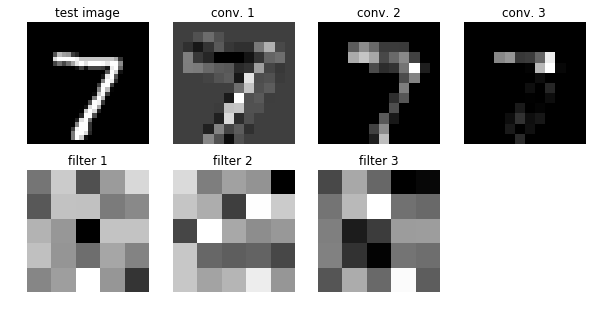

In [0]:
data=[image,*conv,*filters,]
title=['test image','conv. 1','conv. 2','conv. 3','filter 1','filter 2','filter 3']
plt.figure(figsize=(10,5))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.imshow(data[i],cmap='gray')
    plt.title(title[i])
    plt.axis('off')

## Remove one convolutional layer

In [11]:
#model with fewer convolutional layers
w_1_new = init_weights((32, 1, 5, 5))
w_3_new = init_weights((128, 32, 3,3))
w_conv1_new = [w_1_new, w_3_new]

w_h2_new = init_weights((128*25, 625))
w_o_new = init_weights((625, 10))
#prelu constant
a_2_new = init_weights((1,625))
optimizer_new = RMSprop([*w_conv1_new, w_h2_new, w_o_new, a_2_new])

for i in range(10):
    print('Epoch %i'%i)
    for (j, (X, y)) in enumerate(dataloader, 0):
        optimizer_new.zero_grad()
        noise = torch.tensor([])
        noise=model(X.reshape(mb_size, -1), w_conv1_new, w_h2_new, w_o_new, a_2_new, 0.8, 0.7,number_of_output_pixel=3200)
        cost = torch.nn.functional.cross_entropy(noise, y)
        cost.backward()
        if j%100==0:
            print(j,"Loss: {}".format(cost))
        optimizer_new.step()

Epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


0 Loss: 8.198566436767578
100 Loss: 0.25211766362190247
200 Loss: 0.15495595335960388
300 Loss: 0.05368582159280777
400 Loss: 0.10144832730293274
500 Loss: 0.05655602365732193
Epoch 1
0 Loss: 0.045855067670345306
100 Loss: 0.012210994027554989
200 Loss: 0.07361559569835663
300 Loss: 0.05953839421272278
400 Loss: 0.21496132016181946
500 Loss: 0.2773759067058563
Epoch 2
0 Loss: 0.15119895339012146
100 Loss: 0.034387730062007904
200 Loss: 0.13777832686901093
300 Loss: 0.04217636212706566
400 Loss: 0.08751045167446136
500 Loss: 0.17050892114639282
Epoch 3
0 Loss: 0.03309304639697075
100 Loss: 0.030630258843302727
200 Loss: 0.0879826620221138
300 Loss: 0.05866178870201111
400 Loss: 0.061996642500162125
500 Loss: 0.1360815167427063
Epoch 4
0 Loss: 0.17656266689300537
100 Loss: 0.051665037870407104
200 Loss: 0.19343572854995728
300 Loss: 0.1799963414669037
400 Loss: 0.07805664837360382
500 Loss: 0.002313323086127639
Epoch 5
0 Loss: 0.12455422431230545
100 Loss: 0.03645532205700874
200 Loss: 0

In [13]:
test_acc([ w_conv1_new, w_h2_new, w_o_new, a_2_new, 0.8, 0.7,3200],model)

0.982

| Model                    | Test accuracy |
|--------------------------|------------|
| Standard                 | 97.0%      |
| Dropout                  |            |
| Prelu                    |            |
| Convolutional (3 layers) | 96.9%      |
| Convolutional (2 layers) | 98.2%      |

All of the methods had a high test accuracy